# Analysis framework for rotation period extraction (MSAP4-03)

This notebook provide an example of the analysis performed by the PLATO MSAP4-03 submodules: results from Lomb-Scargle periodogram, autocorrelation functions and composite spectrum are used to produce a set of features exploited by an existing instance of ROOSTER to return the final rotation period of the analysed target. You will find that what is done here is very similar to the ROOSTER tutorial notebook (``rooster_training_framework``, you should run it before doing this tutorial), the only big difference is actually that we will use here a pre-trained ROOSTER instance !

Here, the MSAP4-01A and MSAP4-02 steps required to feed MSAP4-03 are included in order to be able to run this notebook independently from the MSAP4-01A and MSAP4-02 notebooks.

Note that, due its significant computing time, the MSAP4-01B component dedicated to background analysis is executed independently in another notebook.

**Note:** This notebook has been designed for the purpose of scientific justification of MSAP4-03. The notebook illustrated the precise flowchart envisaged for MSAP4-03 is cs_rooster_sph_analysis.ipynb

In [1]:
import star_privateer as sp

## A simple example

In [2]:
import importlib
import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt

if not os.path.exists ('stellar_analysis_features') :
    os.mkdir ('stellar_analysis_features')
if not os.path.exists ('stellar_analysis_plots') :
    os.mkdir ('stellar_analysis_plots')    

Our working case is KIC 3733735, a well-known *Kepler* fast rotating star.

In [3]:
filename = sp.get_target_filename (sp.timeseries, '003733735')
t, s, dt = sp.load_resource (filename)

The first thing we have to do is run the analysis pipeline. In particular, we can take a look at the plots made from the different analysis methods. 

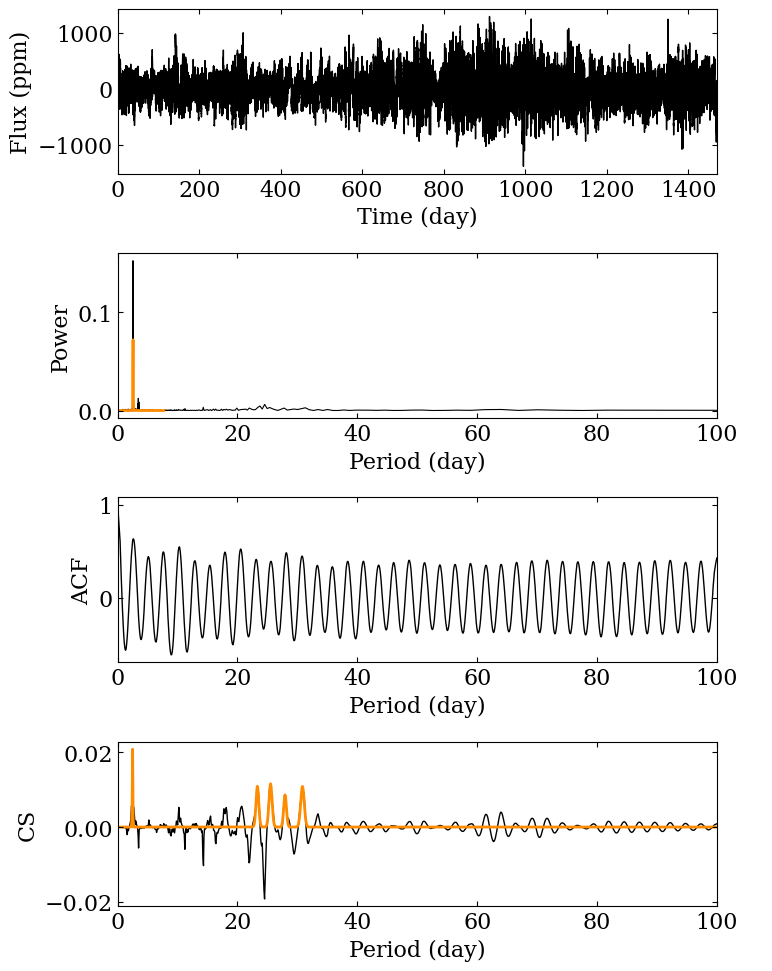

In [4]:
p_in = np.linspace (0, 100, 1000)
(p_ps, p_acf, ps, acf, 
 cs, features, feature_names, _) = sp.analysis_pipeline (t, s, periods_in=p_in, figsize=(8,10),
                                                            wavelet_analysis=False, plot=True,
                                                            filename='stellar_analysis_plots/003733735.png',
                                                        )

We then save the results to a csv file:

In [5]:
fileout = 'stellar_analysis_features/003733735.csv'
df = sp.save_features (fileout, 3733735, features, feature_names)

As in the previous tutorial, let's build a feature catalog. This is actually not required here because we are analysing only one star, but this step allows to ROOSTER-analyse several stars together with a simple framework.

In [6]:
df = sp.build_catalog_features ('stellar_analysis_features')

Then, let's load the ROOSTER instance that we have trained in the previous tutorial:

In [7]:
chicken = sp.load_rooster_instance (filename='rooster_instances/rooster_tutorial')

As previously, let's split the DataFrame into ROOSTER required inputs:

In [8]:
(target_id, p_candidates, 
 e_p_candidates, E_p_candidates, 
 features, feature_names) = sp.create_rooster_feature_inputs (df, return_err=True)

Here, we can see that there is actually (almost) nothing to do, as the three methods have yielded the same $P_\mathrm{rot}$ estimate. However, we need ROOSTER to provide us with the rotation score of the target. ROOSTER will also select one of the three ``p_candidates`` as the final estimate for our target.

In [9]:
p_candidates

array([[2.55994471, 2.59507401, 2.49247385]])

The ``analyseSet`` function implemented in ROOSTER allows to analyse the features we extracted with the analysis pipeline. By providing ``feature_names``, we ensure that ROOSTER was trained with the same features that those we extracted.

In [10]:
rotation_score, prot, e_p, E_p = chicken.analyseSet (features, p_candidates, e_p_err=e_p_candidates,
                                                     E_p_err=E_p_candidates, feature_names=feature_names)

We finally get the rotation score and the final $P_\mathrm{rot}$. A rotation score above 0.5 means that the ROOSTER analysis favours a detection of stellar surface rotation signal.

In [11]:
rotation_score, prot, e_p, E_p

(array([0.82]), array([2.55994471]), array([0.0604509]), array([0.0634239]))

## Analysing a PLATO simulated light curves dataset

In order to illustrate the pipeline features described above, we can apply the pipeline to a larger dataset of 255 PLATO simulated light curves in order to check what we recover.

In [12]:
import plato_msap4_demonstrator_datasets.plato_sim_dataset as plato_sim_dataset

if not os.path.exists ('plato_sim_features') :
    os.mkdir ('plato_sim_features')
if not os.path.exists ('plato_sim_plots') :
    os.mkdir ('plato_sim_plots')

In [13]:
list_id = sp.get_list_targets (plato_sim_dataset)

Note that in the current version of the demonstrator, we apply a 55-day high-pass finite impulse response filter to the simulated light curves (``preprocess``) function in order to remove low-frequency systematics while preserving at most the signature of stellar activity in the data. In the future, data product calibrated specifically for MSAP4 or dedicated calibration step aimed at reducing systematics at most would allow to significantly improve the analysis performances.

In [14]:
for elt in tqdm.tqdm (list_id) :
    str_elt = str (elt).zfill (3)
    fileout = 'plato_sim_features/{}.csv'.format(str_elt)
    filename = sp.get_target_filename (plato_sim_dataset, str_elt, filetype='csv')
    if not os.path.exists (fileout) :
        t, s, dt = sp.load_resource (filename)
        s = sp.preprocess (t, s, cut=55)
        (p_ps, p_acf, ps, acf, 
         cs, features, feature_names, _) = sp.analysis_pipeline (t, s, periods_in=p_in,
                                                                    wavelet_analysis=False, plot=True,
                                                                    filename='plato_sim_plots/{}.png'.format(str_elt),
                                                                    figsize=(10,16),
                                                                    lw=1, dpi=300, smooth_acf=True)
        df = sp.save_features (fileout, str_elt, features, feature_names)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 44256.53it/s]


We can now analyse the obtained features with ROOSTER to provide our final results.

In [15]:
df = sp.build_catalog_features ('plato_sim_features')
(target_id, p_candidates, 
 e_p_candidates, E_p_candidates, 
 features, feature_names) = sp.create_rooster_feature_inputs (df, return_err=True)
rotation_score, prot, e_p, E_p = chicken.analyseSet (features, p_candidates, e_p_err=e_p_candidates,
                                                     E_p_err=E_p_candidates, feature_names=feature_names)
df

prot_ps   prot_acf    prot_cs  e_prot_ps  E_prot_ps  e_prot_acf  \
target_id                                                                      
0          43.384664  32.631736  29.219674   1.152496   1.216480        -1.0   
1          33.054982  11.208262  16.348645   4.861871   6.916978        -1.0   
2          17.353865  18.215161  17.308824   2.362525   3.234358        -1.0   
3          21.034988  20.923477  20.924822   2.248453   2.852080        -1.0   
4          28.923109   7.708284   8.893554   0.722536   0.760135        -1.0   
...              ...        ...        ...        ...        ...         ...   
250        31.552483  29.027592  31.219175   5.676881   8.918001        -1.0   
251        20.416312  19.117933  20.219246   2.109279   2.665563        -1.0   
252        36.534454  37.638648  36.899833   4.307302   5.618974        -1.0   
253        17.353865  17.416555  17.478516   3.479639   5.770656        -1.0   
254        18.760936  18.819324  19.007517   2.696398   3.768938        -1.0   

           E_prot_acf  e_prot_cs  E_prot_cs       sph_ps      sph_acf  \
target_id                                                               
0                -1.0   1.242817   1.242817   754.547891   747.270985   
1                -1.0   3.874861   3.874861   196.002432   197.573001   
2                -1.0   0.424494   0.424494   130.530199   132.035535   
3                -1.0   0.727613   0.727613   107.469907   107.619504   
4                -1.0   2.896222   2.896222   156.269982   149.832641   
...               ...        ...        ...          ...          ...   
250              -1.0   3.982823   3.982823   215.787517   205.336661   
251              -1.0   1.734646   1.734646   184.403461   175.416258   
252              -1.0   4.736251   4.736251  1353.429169  1370.863674   
253              -1.0   2.233398   2.233398   163.173697   163.119816   
254              -1.0   0.604807   0.604807  1162.545259  1161.618942   

                sph_cs      h_ps     fa_prob_ps      hacf      gacf       hcs  
target_id                                                                      
0           722.371710  0.243752   0.000000e+00  0.204530  0.417558  0.457579  
1           217.818959  0.016114   0.000000e+00 -0.154258  0.000649  0.489209  
2           130.541438  0.083866   0.000000e+00  0.271299  0.626426  0.889873  
3           107.619504  0.152170   0.000000e+00  0.552096  1.054497  0.983289  
4           149.472409  0.011790  4.780577e-250 -0.077873  0.002125  0.357145  
...                ...       ...            ...       ...       ...       ...  
250         202.222122  0.160314   0.000000e+00  0.561387  1.081777  0.855115  
251         184.363934  0.160625   0.000000e+00  0.397343  0.852581  0.851365  
252        1358.401532  0.250936   0.000000e+00  0.752538  1.515209  0.986710  
253         163.063621  0.078761   0.000000e+00  0.332430  0.760885  0.981911  
254        1157.821920  0.253955   0.000000e+00  0.343084  0.878379  0.973676  

[255 rows x 17 columns]

Next, let's load the reference catalog for these simulated light curves in order to compare the results from our pipeline with what was injected in the data.

In [16]:
prot_ref = sp.get_prot_ref (target_id, catalog='plato-sim')
cond_0 = (rotation_score>0.5)
cond_1 = (np.abs (prot - prot_ref) < 0.1 * prot_ref) 
cond_2 = (np.abs (prot - prot_ref) < 0.1 * prot_ref) & (rotation_score>0.5)
score_0 = target_id[cond_0].size / target_id.size
score_1 = target_id[cond_1].size / target_id.size
score_2 = target_id[cond_2].size / target_id.size
score_0, score_1, score_2

(0.9450980392156862, 0.6274509803921569, 0.6078431372549019)

The score computed here means that we were able to successfully detect a rotation signal and recover the correct rotation period for about **61% of the stars** in the sample. We can take a look at histograms to check the rotation score of our population and to compare the input rotation periods distribution to the one we recover.

(0.0, 80.0)

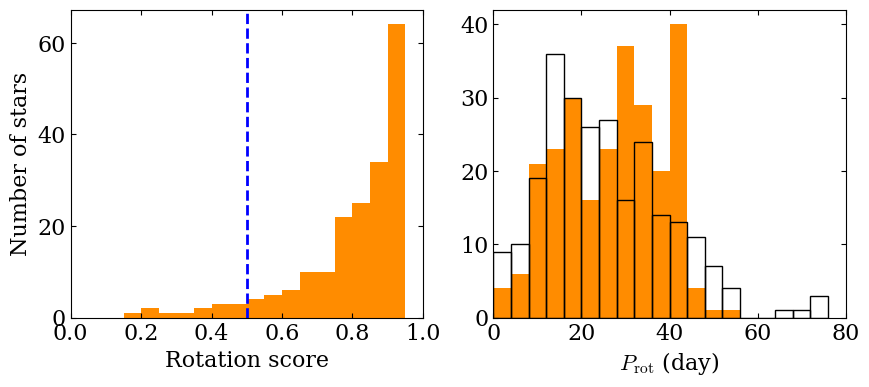

In [17]:
fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(10, 4))

bins = np.linspace (0, 1, 20, endpoint=False)
ax1.hist (rotation_score, bins=bins, color='darkorange')
ax1.axvline (0.5, ls='--', color='blue', lw=2)
bins = np.linspace (0, 80, 20, endpoint=False)
ax2.hist (prot, bins=bins, color='darkorange')
ax2.hist (prot_ref, bins=bins, facecolor='none',
         edgecolor='black', label='Ref')

ax1.set_ylabel (r'Number of stars')
ax1.set_xlabel (r'Rotation score')
ax2.set_xlabel (r'$P_\mathrm{rot}$ (day)')

ax1.set_xlim (0, 1)
ax2.set_xlim (0, 80)